# Realized Variance (RV) Prediction - Models

**Objective:** Predict next-day Realized Variance (RV) using engineered features from high-frequency volatility data

**Dataset:**
- 30 Dow Jones stocks (2003-2024)
- 74 engineered features across 8 categories
- Train: 2003-2018 | Validation: 2019-2021 | Test: 2022-2024

**Approach:** Regression models (XGBoost, LightGBM, Random Forest)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

In [2]:
# Load data from Feature Engineering output
data_path = '../Feature Engineering Group 6/data/engineered/'

train_df = pd.read_parquet(data_path + 'rv_features_train.parquet')
val_df = pd.read_parquet(data_path + 'rv_features_val.parquet')
test_df = pd.read_parquet(data_path + 'rv_features_test.parquet')

print(f"\nOriginal Samples: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"Total Features: {train_df.shape[1]}")

# Create next-day RV as target variable
train_df['RV_t+1'] = train_df.groupby('Ticker')['RV'].shift(-1)
val_df['RV_t+1'] = val_df.groupby('Ticker')['RV'].shift(-1)
test_df['RV_t+1'] = test_df.groupby('Ticker')['RV'].shift(-1)

# Drop rows where target is NaN (last day for each ticker in each split)
train_df = train_df.dropna(subset=['RV_t+1'])
val_df = val_df.dropna(subset=['RV_t+1'])
test_df = test_df.dropna(subset=['RV_t+1'])

print(f"After creating next-day target: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"Dropped rows (last day per ticker): {153575 - (len(train_df) + len(val_df) + len(test_df))}")

# Display sample
print("\nSample of training data (with next-day RV target):")
print(train_df[['Date', 'Ticker', 'RV', 'RV_t+1']].head(10))



Original Samples: 153,575
Total Features: 74
After creating next-day target: 153,486
Dropped rows (last day per ticker): 89

Sample of training data (with next-day RV target):
        Date Ticker       RV   RV_t+1
0 2003-01-02   AAPL   8.3082   6.5682
1 2003-01-03   AAPL   6.5682   7.3444
2 2003-01-06   AAPL   7.3444  10.0133
3 2003-01-07   AAPL  10.0133   6.0982
4 2003-01-08   AAPL   6.0982   5.5478
5 2003-01-09   AAPL   5.5478   7.4340
6 2003-01-10   AAPL   7.4340   6.9826
7 2003-01-13   AAPL   6.9826   5.0252
8 2003-01-14   AAPL   5.0252   5.5881
9 2003-01-15   AAPL   5.5881   7.5931


In [3]:
# Define feature groups
identifier_cols = ['Date', 'Ticker']
target_col = 'RV_t+1'  # Next-day RV as target

# Get all feature columns (exclude identifiers, original RV, and target)
feature_cols = [c for c in train_df.columns if c not in identifier_cols + ['RV', target_col]]

print(f"Total features for modeling: {len(feature_cols)}")
print(f"Target variable: {target_col} (next-day RV)")

# Categorize features for analysis
temporal_features = [c for c in feature_cols if 'lag' in c or 'roll' in c or 'momentum' in c or 'volatility' in c]
decomp_features = [c for c in feature_cols if 'Good' in c or 'Bad' in c or 'jump' in c or 'decomp' in c]
market_features = [c for c in feature_cols if 'market' in c or 'rank' in c or 'vs_market' in c]
freq_features = [c for c in feature_cols if 'freq' in c or 'microstructure' in c]
calendar_features = ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year', 
                     'is_monday', 'is_friday', 'is_month_end']
original_measures = ['BPV', 'Good', 'Bad', 'RQ', 'RV_5', 'BPV_5', 'Good_5', 'Bad_5', 'RQ_5']

Total features for modeling: 71
Target variable: RV_t+1 (next-day RV)


## Feature Scaling & Transformation

In [4]:
# Import scaling libraries
from sklearn.preprocessing import StandardScaler

# Prepare X and y for each dataset (before scaling)
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

# Handle missing values first (lag features at start of time series)
missing_counts = X_train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_counts) > 0:
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)

log_transform_features = [
    # Original volatility measures - always positive
    'BPV', 'Good', 'Bad', 'RQ',
    # 5-min measures - always positive
    'RV_5', 'BPV_5', 'Good_5', 'Bad_5', 'RQ_5',
    # Lagged features - always positive
    'RV_lag1', 'RV_lag5', 'RV_lag10', 'RV_lag20',
    # Rolling statistics - always positive
    'RV_roll_mean_5', 'RV_roll_std_5', 'RV_roll_min_5', 'RV_roll_max_5',
    'RV_roll_mean_20', 'RV_roll_std_20', 'RV_roll_min_20', 'RV_roll_max_20',
    'RV_roll_mean_60', 'RV_roll_std_60', 'RV_roll_min_60', 'RV_roll_max_60',
    # Market-wide measures - always positive
    'market_RV_mean', 'market_RV_median', 'market_RV_std', 'market_RV_min', 'market_RV_max',
    # Other positive volatility features
    'RV_volatility_20', 'jump_intensity', 'market_dispersion'
]

log_transform_features = [f for f in log_transform_features if f in feature_cols]

# Apply log1p transformation
for col in log_transform_features:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    X_test[col] = np.log1p(X_test[col])

nan_count = X_train.isnull().sum().sum()
if nan_count > 0:
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)

no_scale_features = [
    'year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year',
    'is_monday', 'is_friday', 'is_month_end',
    'jump_indicator',
    'RV_is_missing', 'BPV_is_missing', 'Good_is_missing', 'Bad_is_missing',
]

# Features to scale
scale_features = [f for f in feature_cols if f not in no_scale_features]

scaler = StandardScaler()
scaler.fit(X_train[scale_features])

# Transform all datasets
X_train[scale_features] = scaler.transform(X_train[scale_features])
X_val[scale_features] = scaler.transform(X_val[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

y_train_original = y_train.copy()
y_val_original = y_val.copy()
y_test_original = y_test.copy()

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nLog-transformed features: {len(log_transform_features)}")
print(f"StandardScaled features: {len(scale_features)}")
print(f"Unscaled features: {len(no_scale_features)}")

X_train: (114029, 71)
X_val: (22627, 71)
X_test: (16830, 71)

Log-transformed features: 33
StandardScaled features: 57
Unscaled features: 14


In [5]:
# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train model
rf_model.fit(X_train, y_train)

y_train_pred_rf_log = rf_model.predict(X_train)
y_val_pred_rf_log = rf_model.predict(X_val)

# Evaluate model performance
def evaluate_model(y_true_log, y_pred_log):
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae = mean_absolute_error(y_true_log, y_pred_log)
    r2 = r2_score(y_true_log, y_pred_log)
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

rf_train_metrics = evaluate_model(y_train, y_train_pred_rf_log)
rf_val_metrics = evaluate_model(y_val, y_val_pred_rf_log)


In [6]:
# Initialize XGBoost
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_train_pred_xgb_log = xgb_model.predict(X_train)
y_val_pred_xgb_log = xgb_model.predict(X_val)

# Evaluate in log-space
xgb_train_metrics = evaluate_model(y_train, y_train_pred_xgb_log)
xgb_val_metrics = evaluate_model(y_val, y_val_pred_xgb_log)


In [7]:
# Initialize LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Add early stopping to prevent overfitting
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgbm.early_stopping(stopping_rounds=50, verbose=False),
        lgbm.log_evaluation(period=0)
    ])

y_train_pred_lgbm_log = lgbm_model.predict(X_train)
y_val_pred_lgbm_log = lgbm_model.predict(X_val)

# Evaluate in log-space (where model was trained)
lgbm_train_metrics = evaluate_model(y_train, y_train_pred_lgbm_log)
lgbm_val_metrics = evaluate_model(y_val, y_val_pred_lgbm_log)

In [8]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Train_RMSE': [rf_train_metrics['RMSE'], xgb_train_metrics['RMSE'], lgbm_train_metrics['RMSE']],
    'Train_R2': [rf_train_metrics['R2'], xgb_train_metrics['R2'], lgbm_train_metrics['R2']],
    'Train_MAE': [rf_train_metrics['MAE'], xgb_train_metrics['MAE'], lgbm_train_metrics['MAE']],
    'Val_RMSE': [rf_val_metrics['RMSE'], xgb_val_metrics['RMSE'], lgbm_val_metrics['RMSE']],
    'Val_R2': [rf_val_metrics['R2'], xgb_val_metrics['R2'], lgbm_val_metrics['R2']],
    'Val_MAE': [rf_val_metrics['MAE'], xgb_val_metrics['MAE'], lgbm_val_metrics['MAE']]
})

print("\nPerformance Comparison (Training & Validation):")
print(comparison_df.to_string(index=False))

# Find best model based on validation R2
best_model_idx = comparison_df['Val_R2'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest Model (by Validation R²): {best_model_name}")
print(f"  Training R²: {comparison_df.loc[best_model_idx, 'Train_R2']:.4f}")
print(f"  Validation R²: {comparison_df.loc[best_model_idx, 'Val_R2']:.4f}")
print(f"  Validation RMSE (log-space): {comparison_df.loc[best_model_idx, 'Val_RMSE']:.4f}")



Performance Comparison (Training & Validation):
        Model  Train_RMSE  Train_R2  Train_MAE  Val_RMSE  Val_R2  Val_MAE
Random Forest      0.1934    0.8957     0.1350    0.3140  0.7319   0.2136
      XGBoost      0.2268    0.8566     0.1609    0.3147  0.7307   0.2142
     LightGBM      0.2557    0.8177     0.1806    0.3037  0.7492   0.2119

Best Model (by Validation R²): LightGBM
  Training R²: 0.8177
  Validation R²: 0.7492
  Validation RMSE (log-space): 0.3037


## Hyperparameter Tuning - LightGBM

In [9]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgbm_base = LGBMRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbose=-1)

random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions,
    n_iter=15,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R² score: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   4.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=8, min_child_samples=10, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=   5.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estima

## Final Model Evaluation


In [10]:
best_lgbm_model = random_search.best_estimator_

y_train_pred_tuned_log = best_lgbm_model.predict(X_train)
y_val_pred_tuned_log = best_lgbm_model.predict(X_val)
y_test_pred_tuned_log = best_lgbm_model.predict(X_test)

train_metrics_tuned = evaluate_model(y_train, y_train_pred_tuned_log)
val_metrics_tuned = evaluate_model(y_val, y_val_pred_tuned_log)
test_metrics_tuned = evaluate_model(y_test, y_test_pred_tuned_log)

print("\nTraining Set Performance (log-space):")
print(f"  RMSE: {train_metrics_tuned['RMSE']:.4f}")
print(f"  MAE:  {train_metrics_tuned['MAE']:.4f}")
print(f"  R²:   {train_metrics_tuned['R2']:.4f}")

print("\nValidation Set Performance (log-space):")
print(f"  RMSE: {val_metrics_tuned['RMSE']:.4f}")
print(f"  MAE:  {val_metrics_tuned['MAE']:.4f}")
print(f"  R²:   {val_metrics_tuned['R2']:.4f}")

print("\nTest Set Performance (log-space):")
print(f"  RMSE: {test_metrics_tuned['RMSE']:.4f}")
print(f"  MAE:  {test_metrics_tuned['MAE']:.4f}")
print(f"  R²:   {test_metrics_tuned['R2']:.4f}")

print("\n" + "="*70)
print("COMPARISON: BASELINE vs TUNED")
print("="*70)

comparison_final = pd.DataFrame({
    'Model': ['Baseline LightGBM', 'Tuned LightGBM'],
    'Train_R2': [lgbm_train_metrics['R2'], train_metrics_tuned['R2']],
    'Train_RMSE': [lgbm_train_metrics['RMSE'], train_metrics_tuned['RMSE']],
    'Val_R2': [lgbm_val_metrics['R2'], val_metrics_tuned['R2']],
    'Val_RMSE': [lgbm_val_metrics['RMSE'], val_metrics_tuned['RMSE']],
    'Test_R2': [None, test_metrics_tuned['R2']],
    'Test_RMSE': [None, test_metrics_tuned['RMSE']]
})

print("\nPerformance Comparison:")
print(comparison_final.to_string(index=False))



Training Set Performance (log-space):
  RMSE: 0.2095
  MAE:  0.1458
  R²:   0.8777

Validation Set Performance (log-space):
  RMSE: 0.3133
  MAE:  0.2195
  R²:   0.7331

Test Set Performance (log-space):
  RMSE: 0.2739
  MAE:  0.1918
  R²:   0.6269

COMPARISON: BASELINE vs TUNED

Performance Comparison:
            Model  Train_R2  Train_RMSE  Val_R2  Val_RMSE  Test_R2  Test_RMSE
Baseline LightGBM    0.8177      0.2557  0.7492    0.3037      NaN        NaN
   Tuned LightGBM    0.8777      0.2095  0.7331    0.3133   0.6269     0.2739


## SHAP Analysis

In [18]:
import shap
import matplotlib.pyplot as plt

# Create explainer
explainer = shap.TreeExplainer(best_lgbm_model)

# Compute SHAP values on validation set
shap_values = explainer.shap_values(X_val)

# === SUMMARY PLOT ===
shap.summary_plot(shap_values, X_val, show=False)
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.savefig("../images/shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# === BAR PLOT ===
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.savefig("../images/shap_bar_plot.png", dpi=300, bbox_inches="tight")
plt.close()

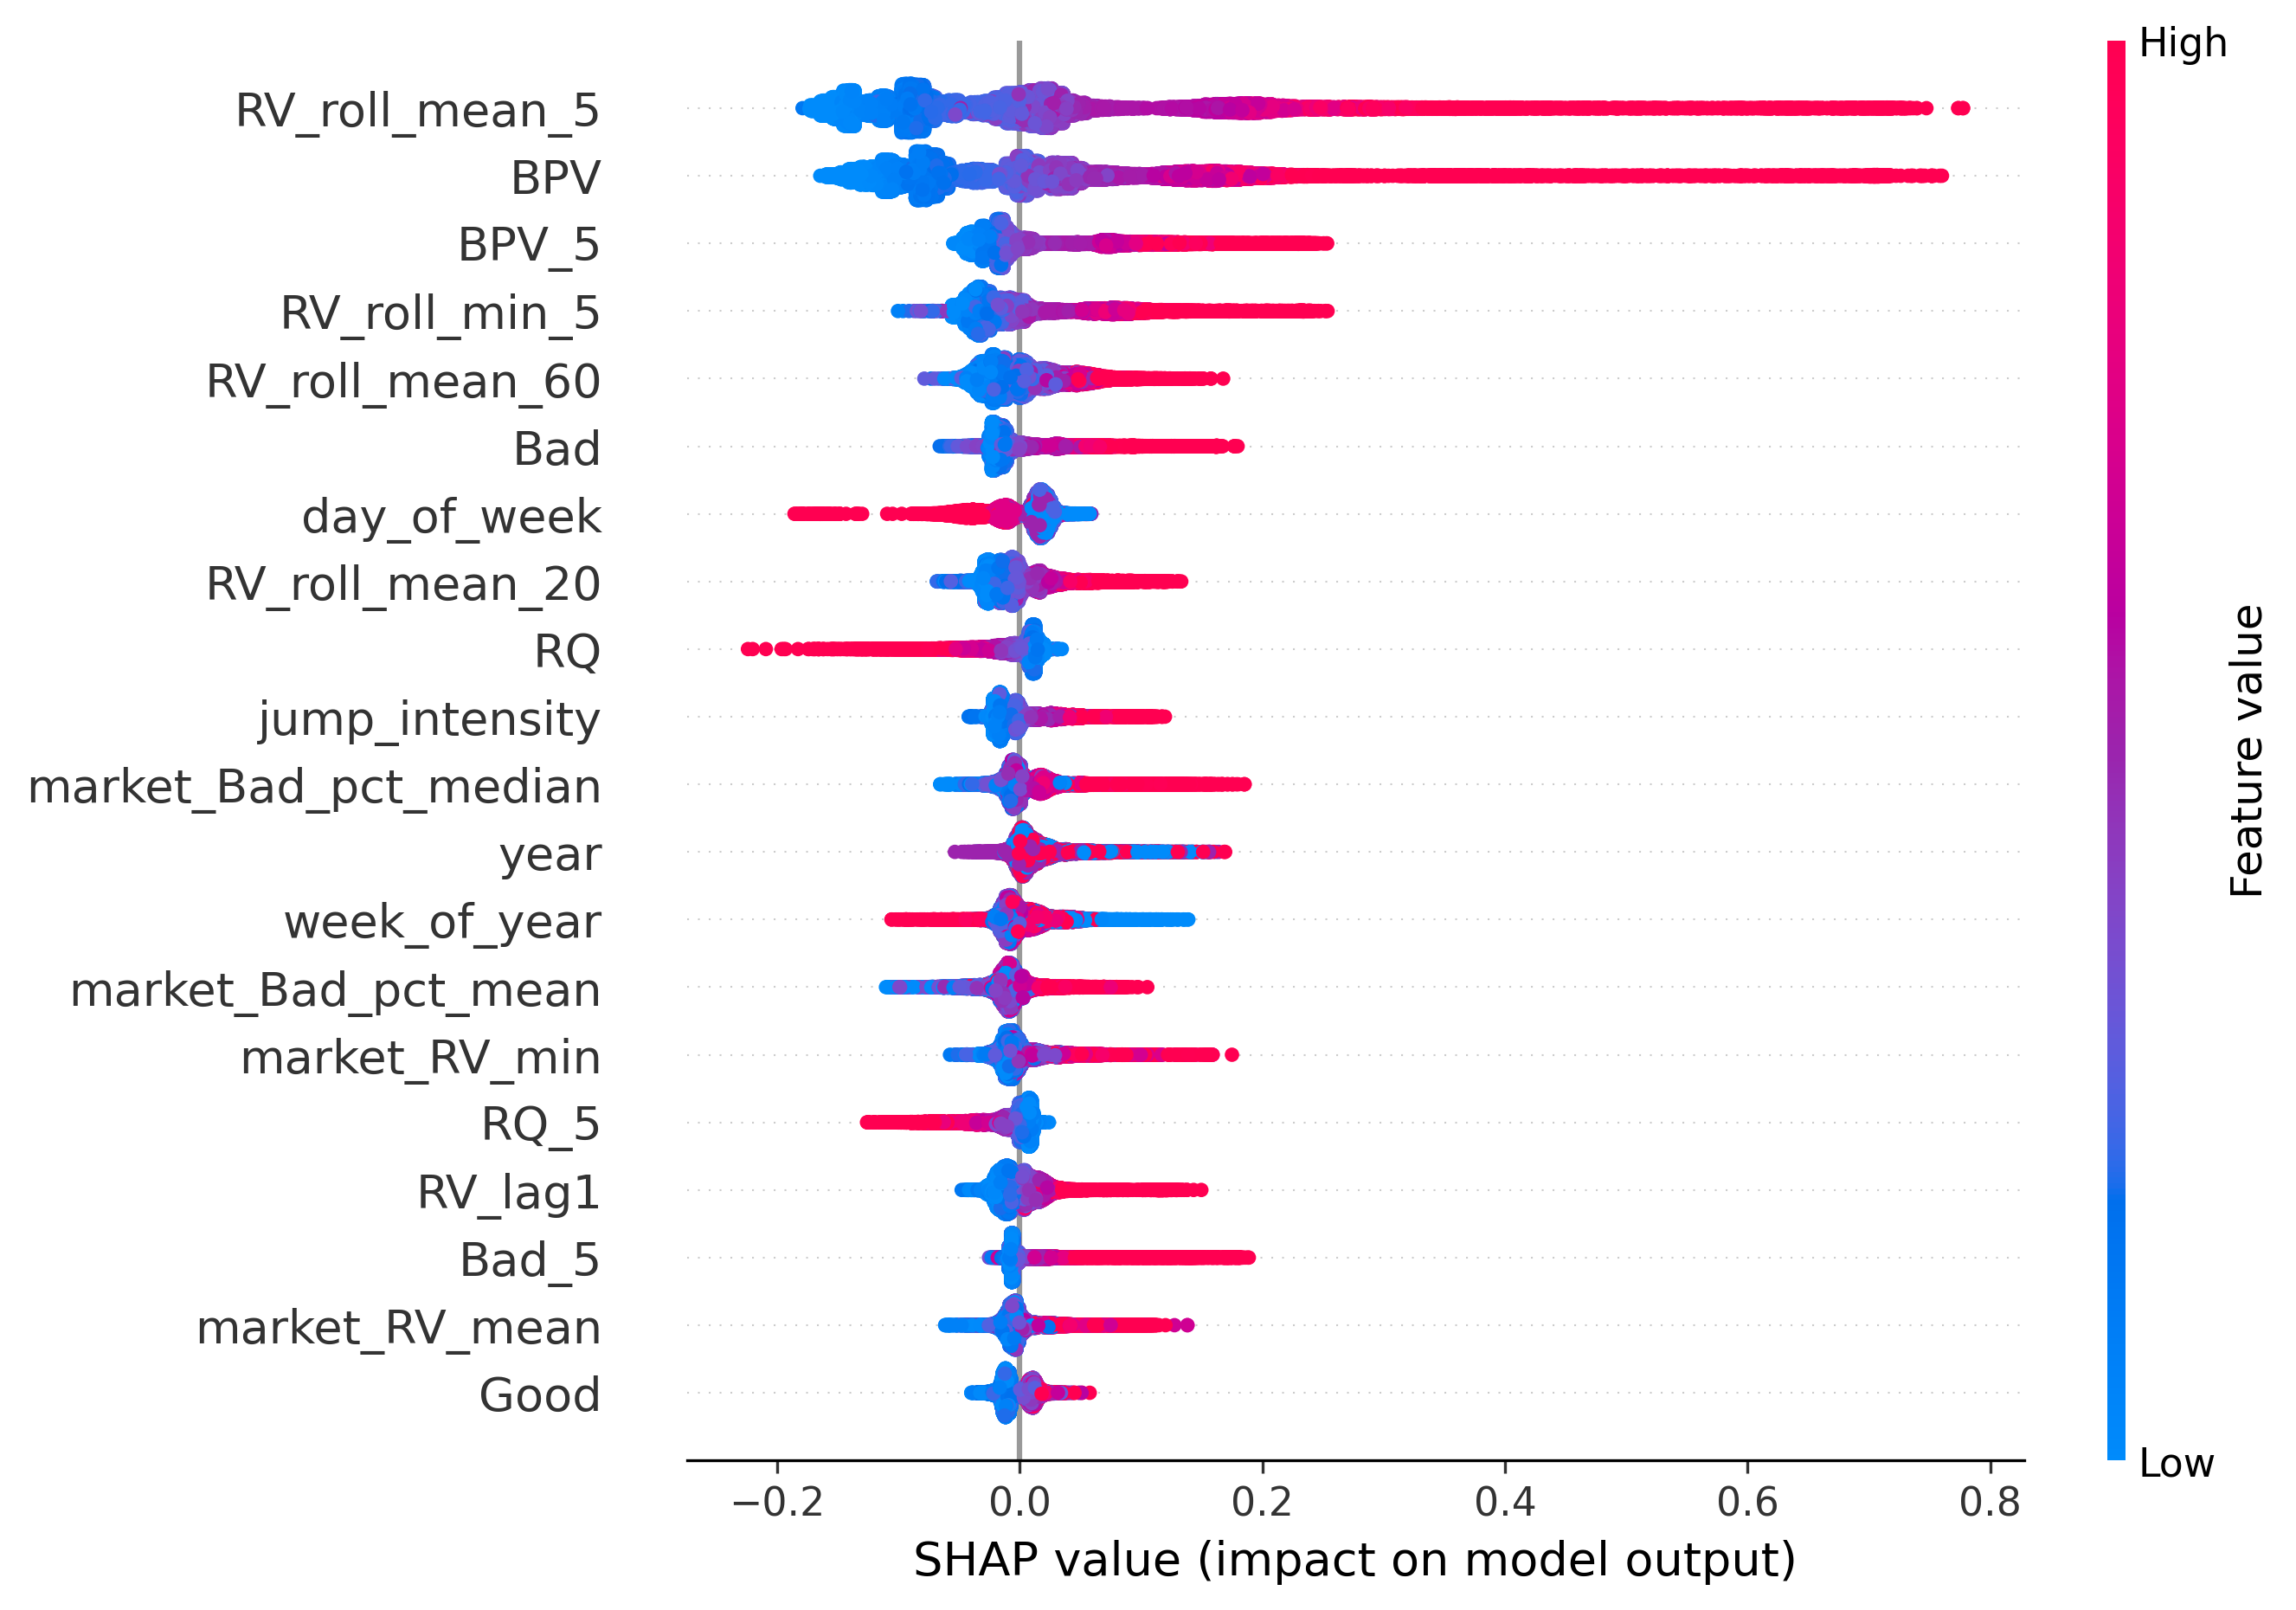

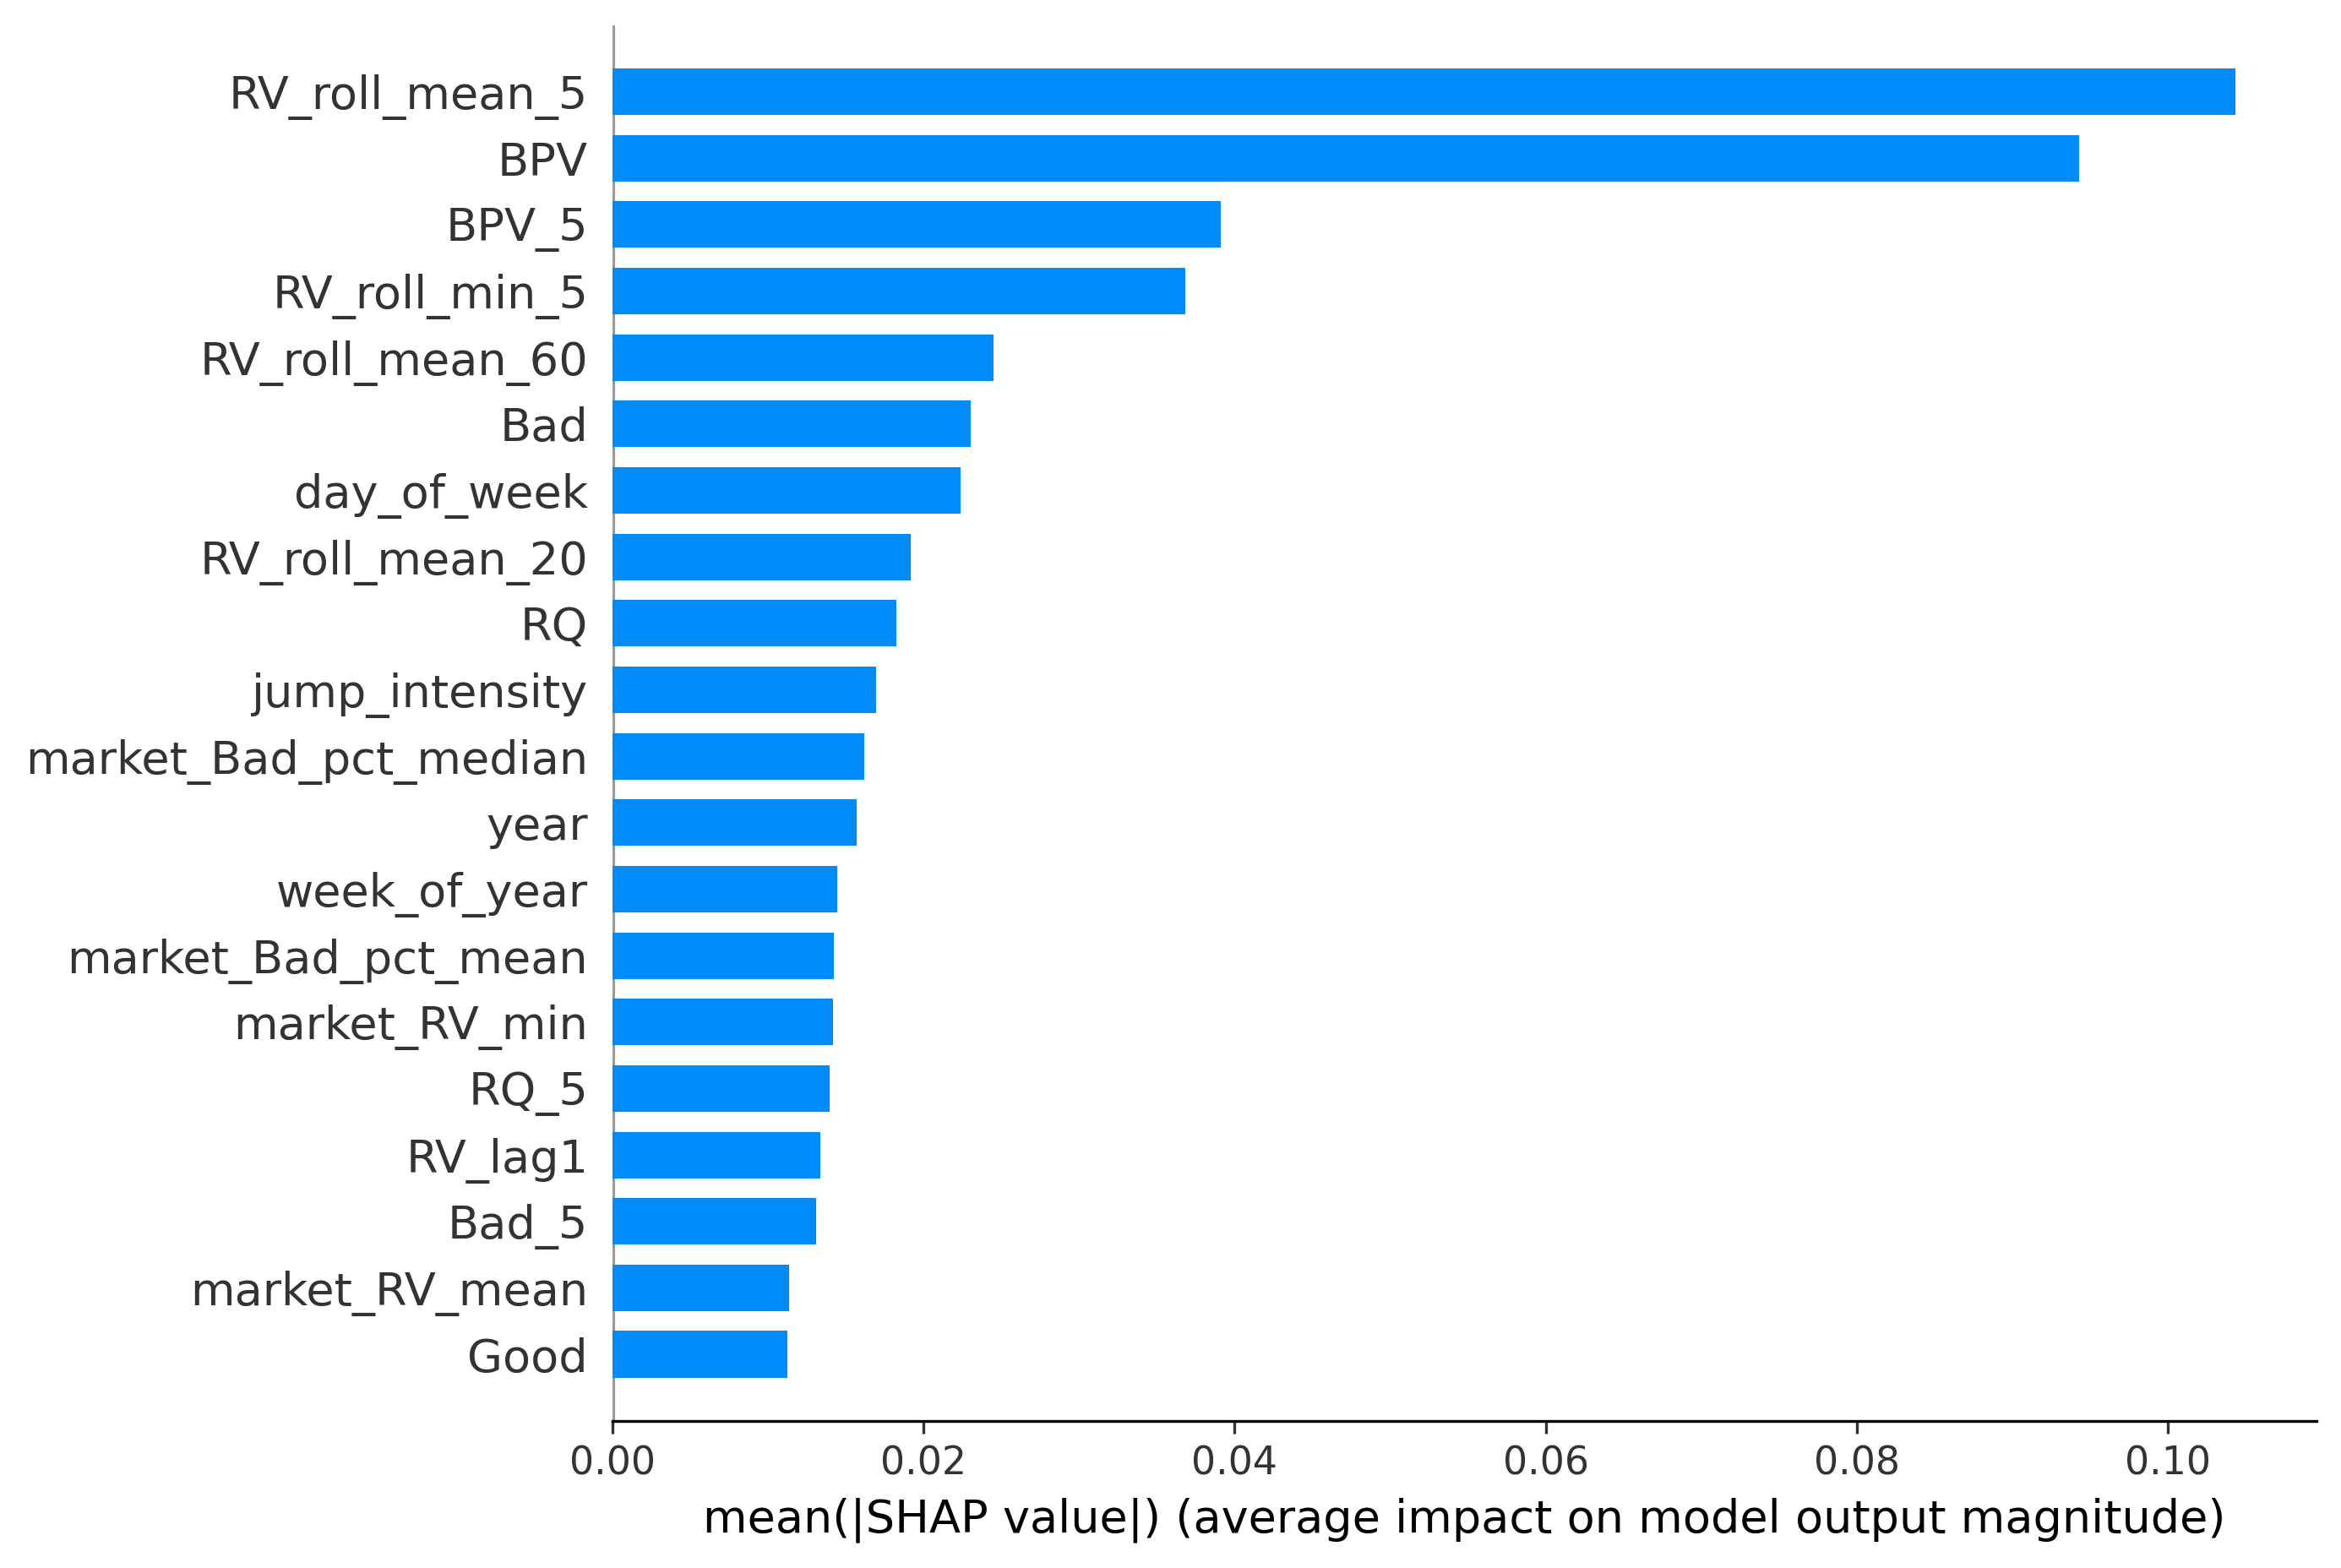

In [20]:
from IPython.display import Image, display

display(Image(filename="../images/shap_summary_plot.png"))
display(Image(filename="../images/shap_bar_plot.png"))

Top SHAP Features (Most Important Predictors of Next-Day RV):
RV_roll_min_5, BPV_5, BPV, RV_roll_mean_5


<Figure size 800x600 with 0 Axes>

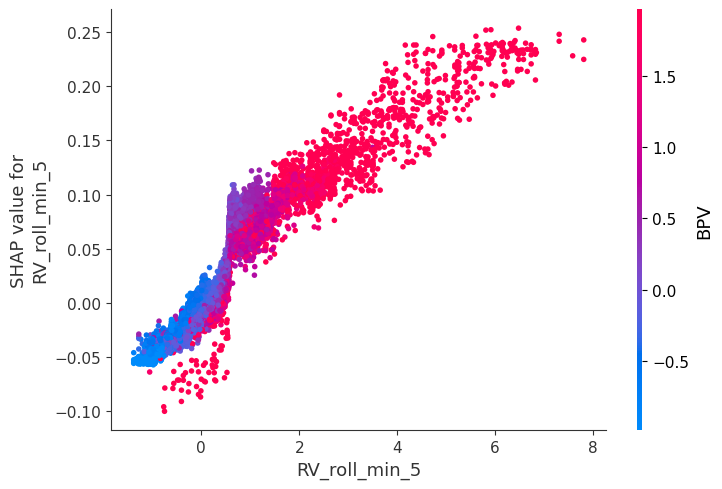

<Figure size 800x600 with 0 Axes>

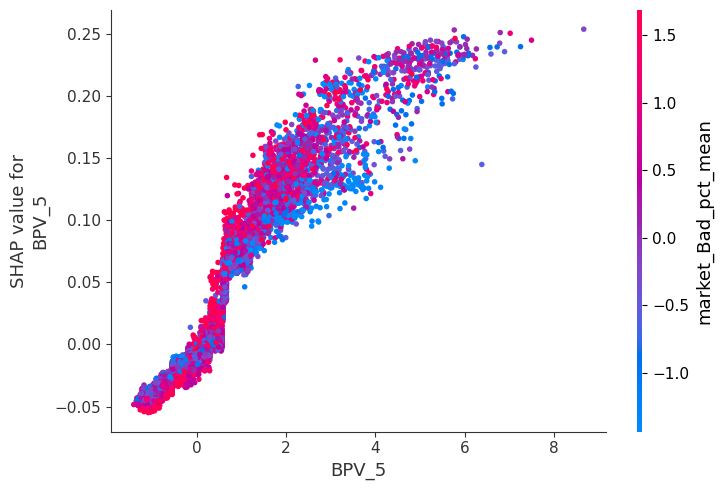

<Figure size 800x600 with 0 Axes>

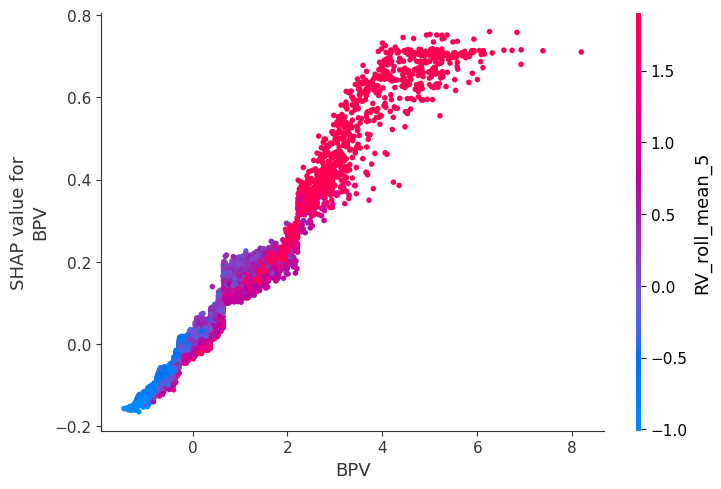

<Figure size 800x600 with 0 Axes>

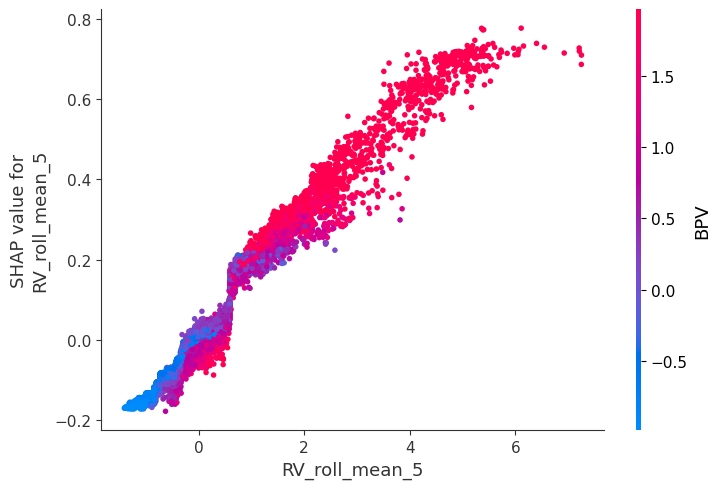

In [21]:
# Identify top 4 important features
top_features = X_val.columns[np.argsort(np.abs(shap_values).mean(axis=0))][-4:]

# === PRINT DESCRIPTION ===
print("Top SHAP Features (Most Important Predictors of Next-Day RV):")
print(", ".join(top_features))

# === PLOT & SAVE DEPENDENCE PLOTS ===
for feat in top_features:
    plt.figure(figsize=(8,6))
    shap.dependence_plot(feat, shap_values, X_val, show=False)
    plt.tight_layout()
    plt.savefig(f"../images/shap_dependence_{feat}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()